<a href="https://colab.research.google.com/github/srinivasanibmbangalore/OpenCVDeepLearningCertification/blob/master/Copy_of_DocumentAlignment_with_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/ml_data/OpenCVCertification/images'
imgPath=root_path+"/empty_form.jpg"
imgPath1=root_path+"/scanned-form.jpg"

Mounted at /content/gdrive


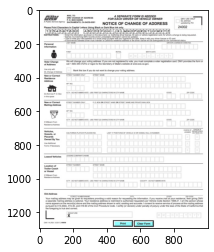

In [ ]:
imReference = cv2.imread(imgPath,1)
if (imReference.any() == None):
  print("Empty Image")
plt.imshow(imReference[...,::-1])

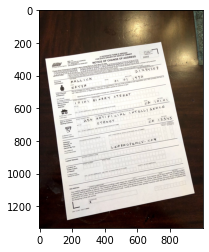

In [ ]:
im = cv2.imread(imgPath1,1)
if (im.any() == None):
  print("Empty Image")
plt.imshow(im[...,::-1])

 The technique we will use is often called “feature based” image alignment because in this technique a sparse set of features are detected in one image and matched with the features in the other image. A transformation is then calculated based on these matched features that warps one image on to the other.

 In many applications, we have two images of the same scene or the same document, but they are not aligned. In other words, if you pick a feature (say a corner) on one image, the coordinates of the same corner in the other image is very different.

Image alignment (also known as image registration) is the technique of warping one image ( or sometimes both images ) so that the features in the two images line up perfectly.

At the heart of image alignment techniques is a simple 3×3 matrix called Homography. If we know 4 or more corresponding points in the two images, we can use the OpenCV function findHomography to find the homography.

### Detect Features

In [ ]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

In [ ]:
# Convert images to grayscale
im1Gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im2Gray = cv2.cvtColor(imReference, cv2.COLOR_BGR2GRAY)

In [ ]:
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

###Match Features

We find the matching features in the two images, sort them by goodness of match and keep only a small percentage of original matches. We finally display the good matches on the images and write the file to disk for visual inspection. We use the hamming distance as a measure of similarity between two feature descriptors. The matched features are shown in the figure below by drawing a line connecting them. Notice, we have many incorrect matches and thefore we will need to use a robust method to calculate homography in the next step.

In [ ]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

# Draw top matches
imMatches = cv2.drawMatches(im, keypoints1, imReference, keypoints2, matches, None)
cv2.imwrite("matches.jpg", imMatches)

True

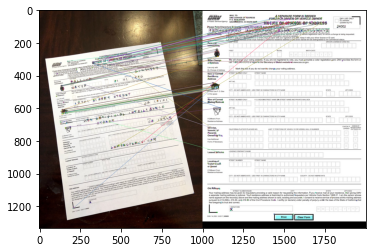

In [ ]:
plt.imshow(imMatches[:,:,::-1])
plt.show()

Calculate Homography
A homography can be computed when we have 4 or more corresponding points in two images. Automatic feature matching does not always produce 100% accurate matches. It is not uncommon for 20-30% of the matches to be incorrect. Fortunately, the findHomography method utilizes a robust estimation technique called Random Sample Consensus (RANSAC) which produces the right result even in the presence of large number of bad matches.

In [ ]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

## Warp the image

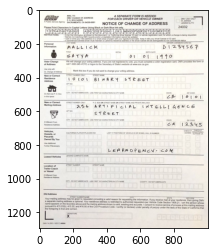

In [ ]:
# Use homography
# Use homography
height, width, channels = imReference.shape
im1Reg = cv2.warpPerspective(im, h, (width, height))
plt.imshow(im1Reg[:,:,::-1])
plt.show()